# Berries price analysis in the spanish market

Market Data Source: 

    Junta de Andalucía (warehouse output prices paid to farmers)

    http://www.juntadeandalucia.es/agriculturaypesca/observatorio/servlet/FrontController?action=Static&subsector=19&url=subsector.jsp

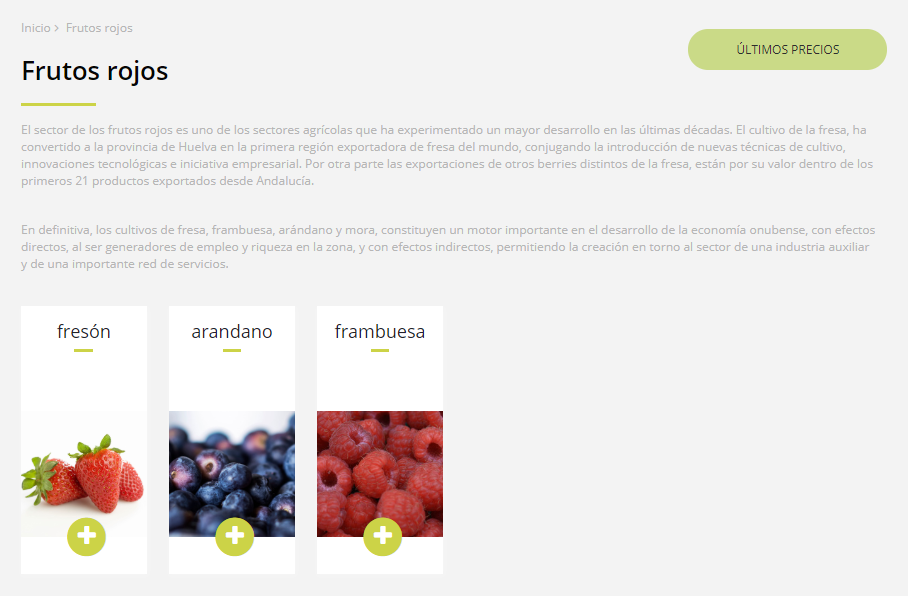

In [1]:
from IPython.display import Image
Image("Data/Website.png")

## Import and cleanance

In [2]:
import pandas as pd
import datetime
pd.set_option('display.max_columns',None) ## Display all columns in pandas dataframe  
pd.set_option('display.max_rows',None) ## Display all rows in pandas dataframe 

sheet_name = 'Observatorio de Precios'
rows_skip_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
rows_skip_14 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
rows_skip_15 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
cols = [0,1]
file_names_year = [  
                    ['Data/ArandanoPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','BLUEBERRIES',0,25],\
                    ['Data/FrambuesaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','RASPBERRIES',35,25],\
                    ['Data/FresaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','STRAWBERRIES',48,22]\
                  ]

price = pd.DataFrame()
price = pd.read_excel(file_names_year[0][0]\
                               ,sheet_name = file_names_year[0][1]\
                               ,header = 6\
                               ,skiprows = file_names_year[0][2]\
                               ,usecols = file_names_year[0][3])
price.columns = ['Week',file_names_year[0][4]]
#price['Crop'] = file_names_year[0][5]
price[['Week_No','Year']] = price.Week.str.split(pat='-',expand=True)
price['Week_No'] = price['Week_No'].astype('int32')
price['Year'] = price['Year'].astype('int32')
price.drop_duplicates(inplace=True)
price['Crop'] = file_names_year[0][5]
price['Week_Campaign'] = price['Week_No'].apply(lambda x: (x - file_names_year[0][6] + 53) % 53 )
price['Week_Campaign'] = price['Week_Campaign'].astype('int32')
price['Year_Campaign'] = price['Week_No'].apply(lambda x : 0 if 0 == file_names_year[0][6] else 0 if x < file_names_year[0][6] else 1)
price['Year_Campaign'] = price['Year_Campaign'].astype('int32')
#price['Year_Campaign'] = price_excel['Year_Campaign'] + price_excel['Year'] 
price.to_excel(f'./Results/Price_Excel{file_names_year[0][5]}.xlsx')
price['Year_Campaign'] = price['Year_Campaign'] + price['Year']

for i in range(1,len(file_names_year)):
    price_excel=pd.read_excel(file_names_year[i][0]\
                               ,sheet_name=file_names_year[i][1]\
                               ,header=6\
                               ,skiprows=file_names_year[i][2]\
                               ,usecols=file_names_year[i][3])
    price_excel.columns = ['Week',file_names_year[i][4]]
    price_excel[['Week_No','Year']] = price_excel.Week.str.split(pat='-',expand=True)
    price_excel['Week_No'] = price_excel['Week_No'].astype('int32')
    price_excel['Year'] = price_excel['Year'].astype('int32')
    price_excel.drop_duplicates(inplace=True)
    price_excel['Crop'] = file_names_year[i][5]
    price_excel['Week_Campaign'] = price_excel['Week_No'].apply(lambda x: (x - file_names_year[i][6] + 53) % 53 )
    price_excel['Week_Campaign'] = price_excel['Week_Campaign'].astype('int32')
    price_excel['Year_Campaign'] = price_excel['Week_No'].apply(lambda x : 0 if 0 == file_names_year[i][6] else 0 if x < file_names_year[i][6] else 1)
    price_excel['Year_Campaign'] = price_excel['Year_Campaign'].astype('int32')
    price_excel['Year_Campaign'] = price_excel['Year_Campaign'] + price_excel['Year'] 
    price = price.append(price_excel)
    price_excel.to_excel(f'./Results/Price_Excel{file_names_year[i][5]}.xlsx')
    price_excel[price_excel['Crop']==file_names_year[i][5]].groupby(['Year_Campaign'])['PriceProducer'].describe().transpose().to_excel(f'./Results/summary_{file_names_year[i][5]}.xlsx')
        
price['Date_Ref']=price['Week'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%V-%G-%u') )
price.drop(range(0,price.PriceProducer.notna().idxmax()),inplace=True)
price = price [['Crop',\
                'PriceProducer',\
                'Week',\
                'Week_No',\
                'Year',\
                'Date_Ref',\
                'Week_Campaign',\
                'Year_Campaign']]
price.dropna(subset=['PriceProducer'], inplace=True)
price['Country']='ES'
price['Currency']='EUR'
price['Measure']='KG'
#Campaign Dates:
    #Strawberry campaign from week 49 to 22
    #Blueberry campaign from week 1 to 25
    #Raspberry campaign from week 36 to 25

In [3]:
price.head()

,Crop,PriceProducer,Week,Week_No,Year,Date_Ref,Week_Campaign,Year_Campaign,Country,Currency,Measure
0,BLUEBERRIES,6.685820,7-2020,7,2020,2020-02-10,7,2020,ES,EUR,KG
1,BLUEBERRIES,6.406843,8-2020,8,2020,2020-02-17,8,2020,ES,EUR,KG
2,BLUEBERRIES,6.123252,9-2020,9,2020,2020-02-24,9,2020,ES,EUR,KG
3,BLUEBERRIES,5.880036,10-2020,10,2020,2020-03-02,10,2020,ES,EUR,KG
4,BLUEBERRIES,5.767417,11-2020,11,2020,2020-03-09,11,2020,ES,EUR,KG


### SQL statements

In [4]:
import pyodbc
from datetime import datetime
connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

qry_max_date = "SELECT max(Date_ref) FROM [Prices].[dbo].[prices] where cast([Country] as nvarchar) = cast('ES' as nvarchar)"
max_date = pd.read_sql(qry_max_date, connStr)
upd = 0

try:
    for index,row in price.iterrows():
        if row['Date_Ref'] > max_date.loc[0].values[0]: # Python price line date must be greater than the max date in SQL table
            cursor.execute("INSERT INTO dbo.prices([Product],[Price],[Country],[Currency],[Measure],[Date_ref],[Week_desc],[Week_num],[Year_num],[Week_num_campaign],[Year_campaign]) values (?,?,?,?,?,?,?,?,?,?,?)",row['Crop'],row['PriceProducer'],row['Country'],row['Currency'],row['Measure'],row['Date_Ref'],row['Week'],row['Week_No'],row['Year'],row['Week_Campaign'],row['Year_Campaign'])
            connStr.commit()
            upd += 1
except TypeError: # If there price is null no posibility to compare operands
    for index,row in price.iterrows(): # When there are no prices in SQL
        cursor.execute("INSERT INTO dbo.prices([Product],[Price],[Country],[Currency],[Measure],[Date_ref],[Week_desc],[Week_num],[Year_num],[Week_num_campaign],[Year_campaign]) values (?,?,?,?,?,?,?,?,?,?,?)",row['Crop'],row['PriceProducer'],row['Country'],row['Currency'],row['Measure'],row['Date_Ref'],row['Week'],row['Week_No'],row['Year'],row['Week_Campaign'],row['Year_Campaign'])
        connStr.commit()
        upd += 1
cursor.close()
connStr.close()
print(upd," new prices added")

2  new prices added
